## Visualizing Model Runs

For each model RunA through RunE for MVE-only and MVE-UDA, all models can be visualized and compared in this notebook. The entire notebook must be run for this.

In [2]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

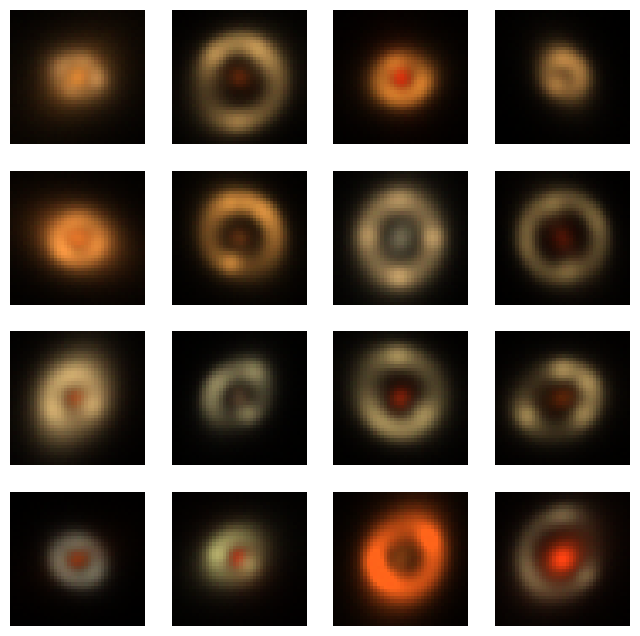

In [4]:
# Visualize source data
visualize_data(source_data)

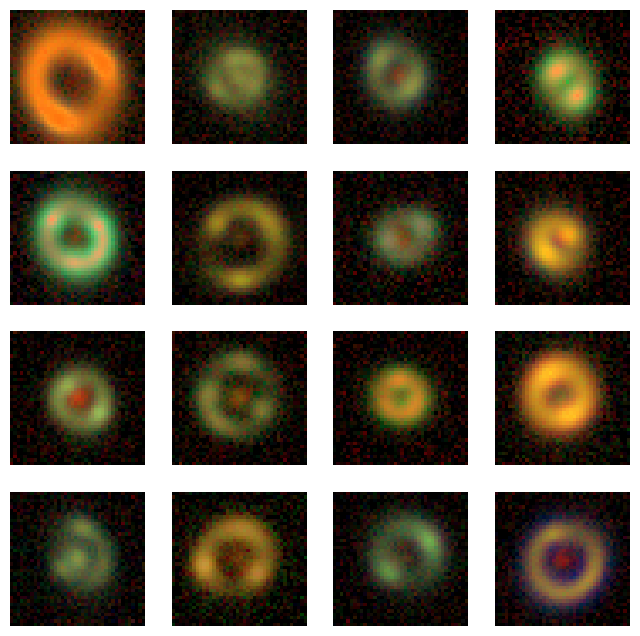

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

This section is not relevant, since this will all be overridden by the saved parameters when we load the model. The individual values below are not important.

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)
    if ((epoch / n_epoch) > 0.5):
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 2e-5
n_epoch = 75
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.4

In [7]:
# Initialize model
model = NeuralNetworkMVEv3(npix=40).cuda()
#model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
from torchsummary import summary

In [9]:
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

## Visualize Results of a Saved Model

Enter the model path in `viz_mod_name` below. The path can be written as in the example below. All results shown are on test data (besides training curves). 
  
Saved models:   
`_final` refers to the model at the final epoch.  
`_mve` refers to the model at the epoch with the best BETA negative log-likelihood on the target data.  
`_nll` refers to the model at the epoch with the best negative log-likelihood on the target data.  
`_snll` refers to the model at the epoch with the best negative log-likelihood on the source data.   
`_#` refers to the run saved periodically at epoch number #.


In [13]:
# Loads a model for plotting/viz

viz_mod_name = "../MVEonly/paper_models/RunC_noDA_snll"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

pd_stats = pd.DataFrame(stats)

These are the stats of the model run as training progressed. In this run, DA-weight and beta were held constant throughout. The train_r2_score goes up to 0.997.

In [14]:
pd_stats

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,val_source_nll_loss,val_target_nll_loss,da_weight,beta,epoch_no
0,0.050488,0.162475,-0.150389,0.500045,0.019186,0.023585,0.941386,0.928877,-0.228815,-0.209377,-1.418994,13.143580,1.4,0.5,89
1,0.050038,0.025575,-0.242663,0.922759,0.018471,0.022131,0.943297,0.933788,-0.245901,-0.235140,-1.478451,-1.397028,1.4,0.5,89
2,0.070461,0.021786,-0.266633,0.933884,0.030193,0.033216,0.907709,0.901230,-0.314784,-0.311353,-0.907251,-0.864461,1.4,0.5,89
3,0.060854,0.046100,-0.211978,0.860934,0.041914,0.044696,0.872205,0.867830,-0.274364,-0.271160,-0.518379,-0.512300,1.4,0.5,89
4,0.070707,0.138061,-0.161242,0.574266,0.046218,0.090035,0.859637,0.731653,-0.275360,-0.221002,-0.660790,13.190704,1.4,0.5,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.086361,0.003278,-0.309236,0.990050,0.001156,0.004958,0.996448,0.985220,-0.354410,-0.347324,-1.262902,-1.239185,1.4,0.5,89
85,0.083088,0.001718,-0.332915,0.994860,0.008193,0.014801,0.974415,0.955525,-0.279405,-0.261824,-1.621850,-1.514945,1.4,0.5,89
86,0.092308,0.005022,-0.252728,0.984736,0.001744,0.006832,0.994686,0.979351,-0.264822,-0.246020,-1.949467,-1.818558,1.4,0.5,89
87,0.103322,0.001647,-0.186443,0.995019,0.001642,0.007835,0.994936,0.976463,-0.112353,0.134176,-2.707123,506.131636,1.4,0.5,89


Below is an isomap visualization of this particular run. We can see how the source and target embeddings are distributed in the two-component reduced space. The colormap indicates the theta_E values of the subset of data used in the visualization. 

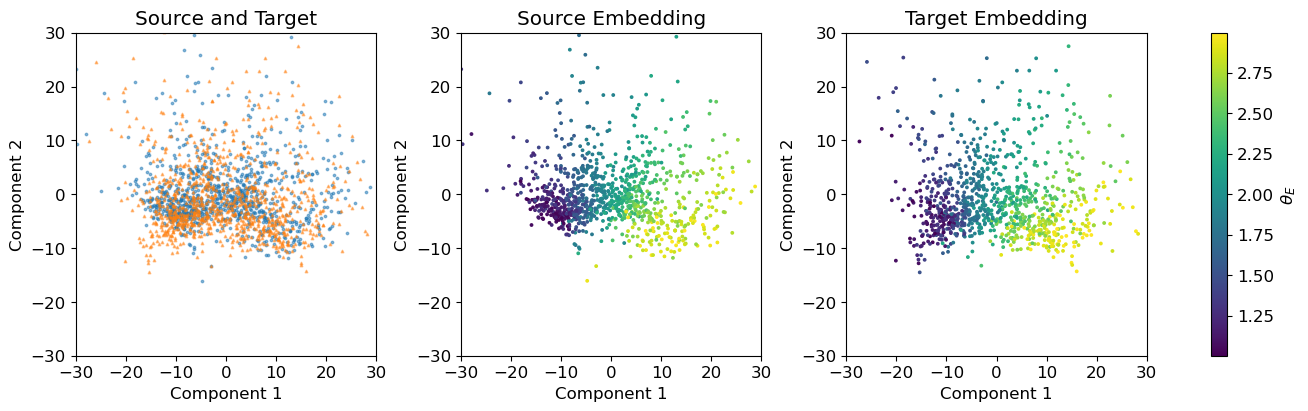

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [15]:
# Visualize isomaps 
plt.rcParams.update({'font.size': 12})
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 30)

Here is the same in a different formatting.

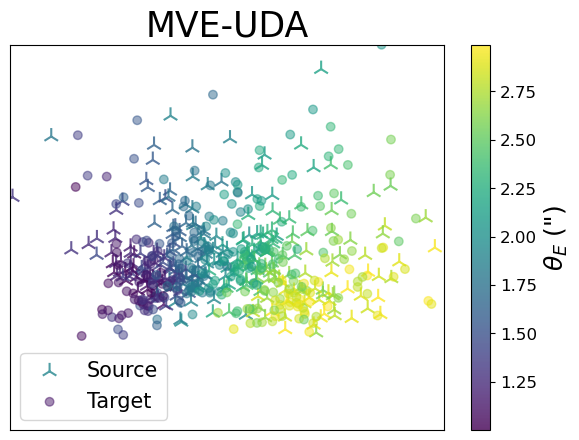

In [22]:
axlim = 30 # axes scale length
cx = 0 # X-center of Xlims
cy = 3 # Y-center of Ylims
n = 300 # Number of points to show
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5),)
s = ax1.scatter(trained_source_iso[:, 0][:n], trained_source_iso[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n], 
           label = "Source")
ax1.scatter(trained_target_iso[:, 0][:n], trained_target_iso[:, 1][:n], s=150, marker='.', alpha = 0.5, c = isomap_target_label_sample[:n],
           label = "Target")
ax1.set_xlim(-axlim + cx, axlim + cx)
ax1.set_ylim(-axlim + cy, axlim + cy)
ax1.set_title('MVE-UDA', fontsize = 25)

# Remove axis ticks and labels
# xl, xr = ax1.get_xlim()
# yl, yr = ax1.get_ylim()
# xt = np.int32(np.linspace(xl, xr, 5))
# yt = np.int32(np.linspace(yl, yr, 5))

# ax1.set_xticks(xt)
# ax1.set_yticks(yt)
# ax1.set_xticklabels(xt)
# ax1.set_yticklabels(yt)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.legend(fontsize = 15)
cbar = plt.colorbar(s, ax = ax1)
cbar.set_label("$\\theta_E$ (\")",size=18)
cbar.ax.tick_params(labelsize=12) #.set_label(label = "$\\theta_E$ (\")", labelsize=18)
#plt.savefig("post_isomap_da.png", bbox_inches = 'tight', dpi = 400)

### Training Curves

Even the DA Loss was tracked in the MVE-only versions in case a comparison was of interest.

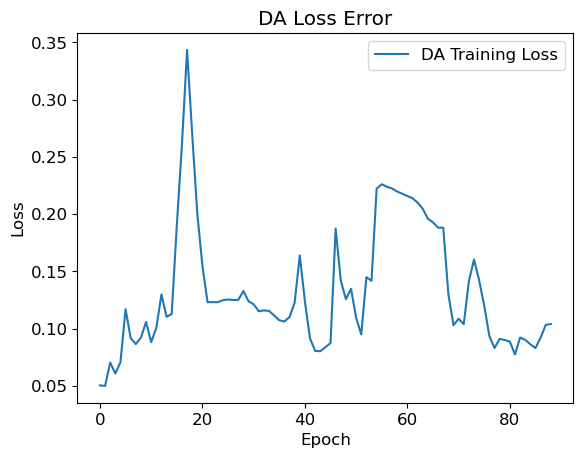

In [24]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.ylim(0.001, 0.05)
#plt.xlim(200, 300)

(0.0, 0.1)

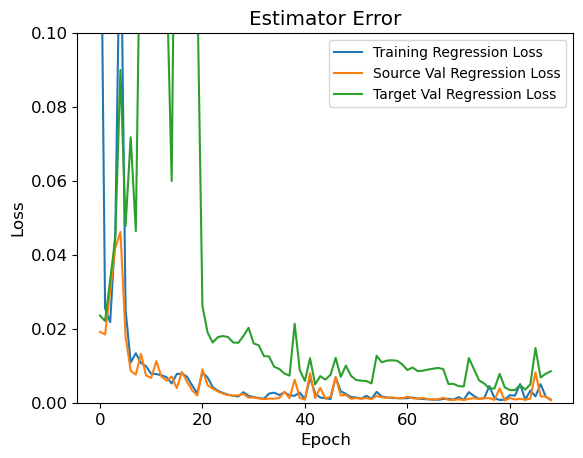

In [25]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(0, 0.10)

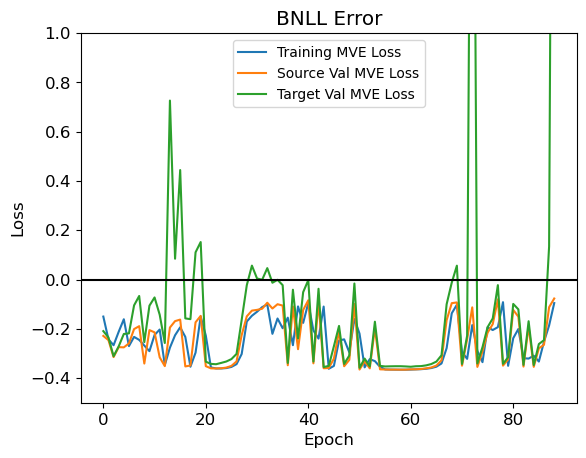

In [26]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
# plt.ylim(-2, 2)
# plt.xlim(100, 300)
plt.ylim(-0.5, 1)
plt.axhline(0, color = 'k')

(-3.0, 2.0)

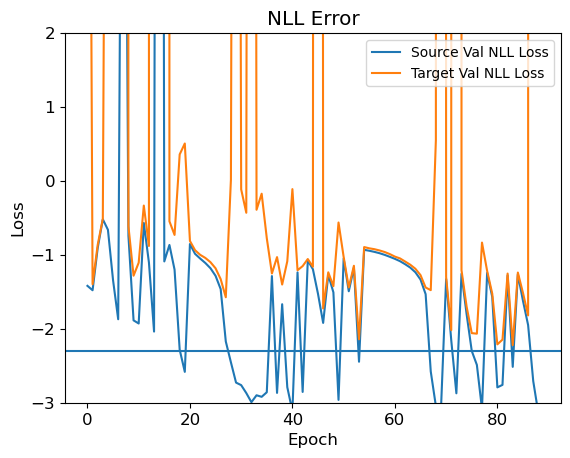

In [27]:
# BNLL for MVE
plt.title("NLL Error")
plt.plot()
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.axhline(-2.3)
plt.ylim(-3, 2)
#plt.xlim(-10, 260)

(0.7, 1.0)

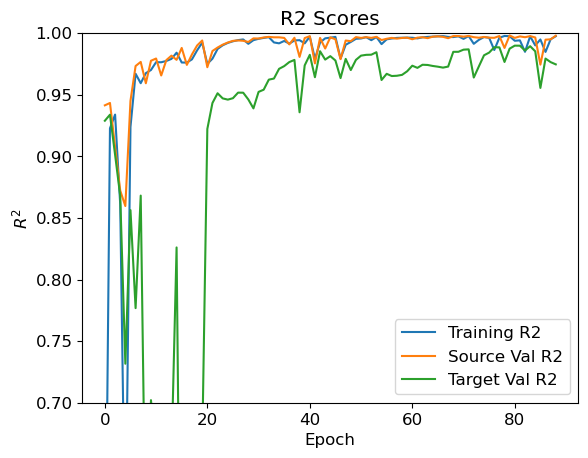

In [28]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.7, 1)

### $R^2$ Scores on Source and Target Data

Testing accuracy of the saved model.

In [29]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9979


Text(0.5, 1.0, 'MMD | Source | R2: 0.998')

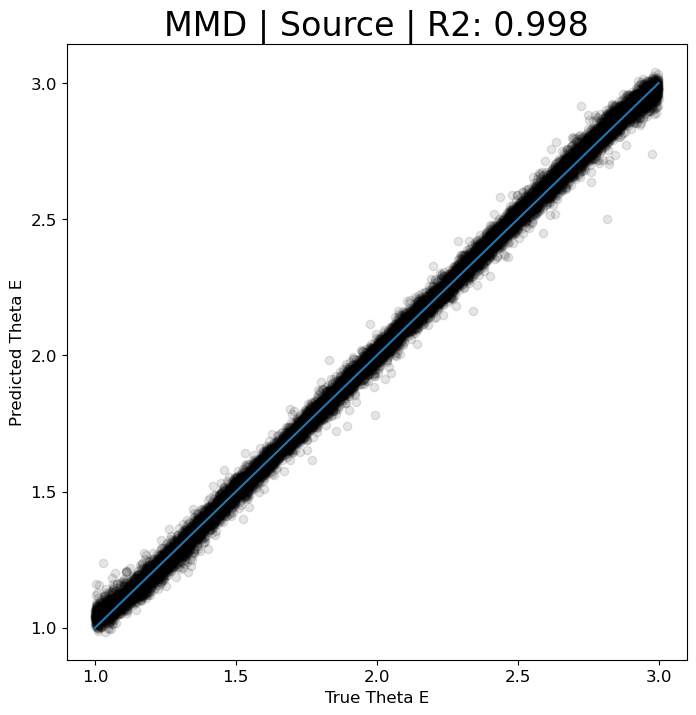

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Uncertainty varies as a function of $\theta_E$.

Text(0.5, 1.0, 'Uncertainty | Source | NLL: -3.146')

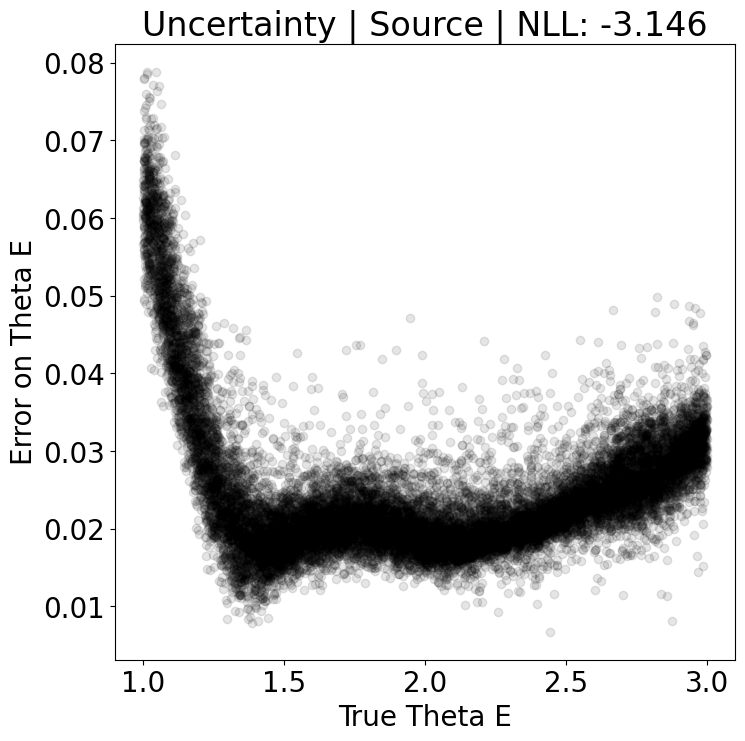

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [32]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9721


Text(0.5, 1.0, 'MMD | Target | R2: 0.972')

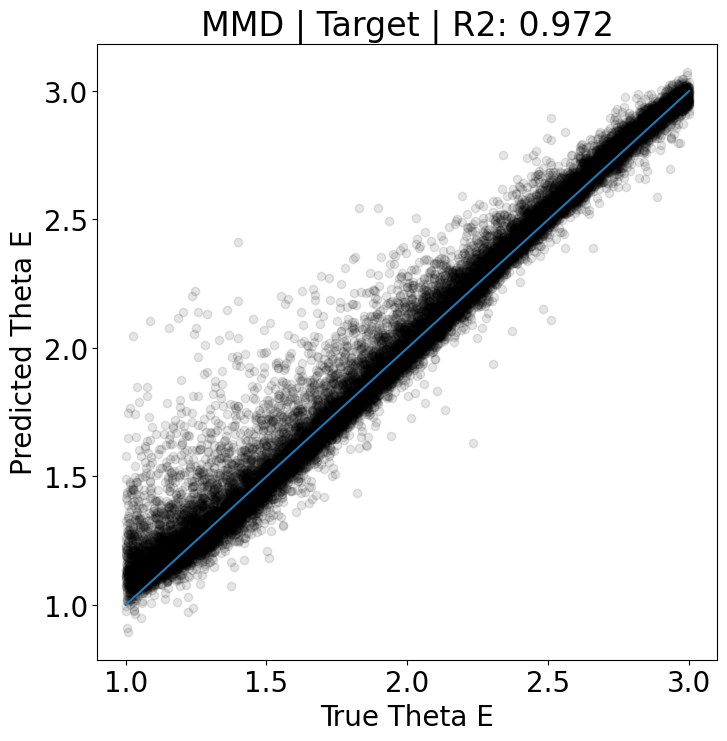

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Uncertainty of MVE-only model behaves poorly on target data.

Text(0.5, 1.0, 'Uncertainty | Target | NLL: 16544.227')

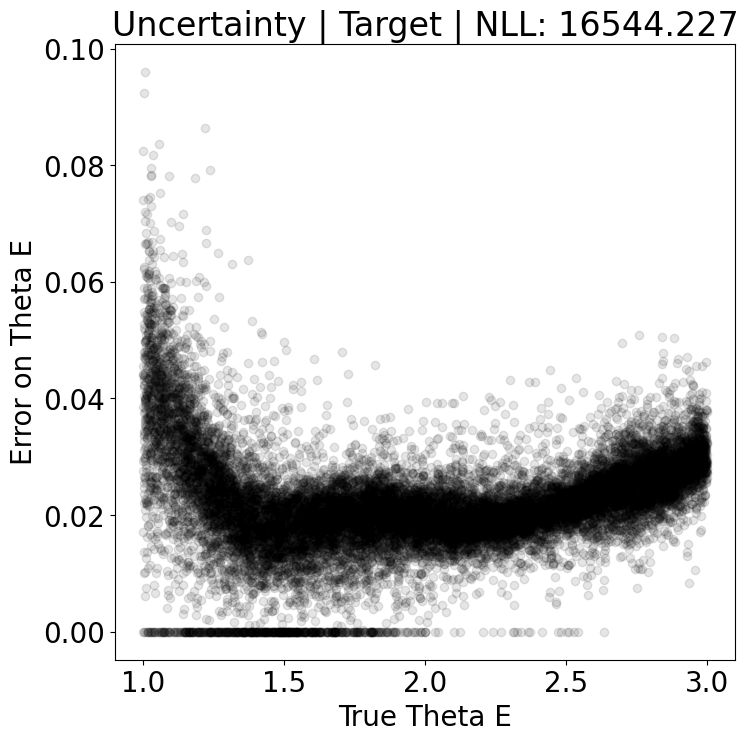

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | NLL: {0:.3f}'.format(np.mean(lbnll_target)))

### Uncertainty Checks

Sample variance should be on the order of the estimated uncertainties.

In [35]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

0.02589789921085038


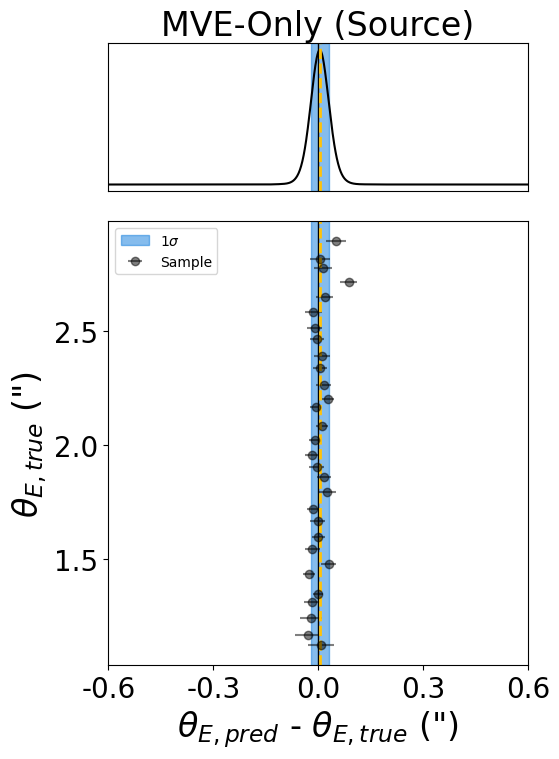

In [36]:
from scipy.stats import gaussian_kde
bins = np.linspace(1.1, 2.9, 60)
indices = np.digitize(true_source, bins) - 1 
ord_idx = np.array([np.random.choice(np.where((indices == k) & (var_preds_source > 0))[0], 1) for k in range(0, 60, 2)])
n_points = 30
rand_idx = ord_idx[:, 0]
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_source - true_source
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)
lims = 0.6

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))

kde = gaussian_kde(resid_all, bw_method=0.5)
x_vals = np.linspace(-lims, lims, 1000)
kde_values = kde(x_vals)

# Plot the histogram
ax_hist.plot(x_vals, kde_values, color = 'k')
ax_hist.set_title('MVE-Only (Source)')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=true_source[rand_idx], xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k', label = "Sample")
ax_resid.set_xlabel(r'$\theta_{E, pred}$ - $\theta_{E, true}$ (")', fontsize = 24)
ax_resid.set_ylabel(r'$\theta_{E, true}$ (")', fontsize = 24)
ax_resid.axvline(0, color = 'k', ls = '-', lw = 1)
ax_hist.axvline(0, color = 'k', ls = '-', lw = 1)

#ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_hist.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_hist.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.legend(loc = 'upper left', fontsize = 10)
#ax_resid.sharex(ax_hist)
ax_hist.set_yticks([])

xt = np.linspace(-lims, lims, 5).round(2)
ax_resid.set_xticks(xt)
ax_resid.set_xticklabels(xt)

ax_hist.set_xticks([])
ax_hist.set_yticklabels([])
ax_hist.set_xlim(-lims, lims)
ax_resid.set_xlim(-lims, lims)
print(sv)

plt.tight_layout()
plt.savefig("source_resid_noDA.png", bbox_inches = 'tight', dpi = 400)

0.09140081397795577


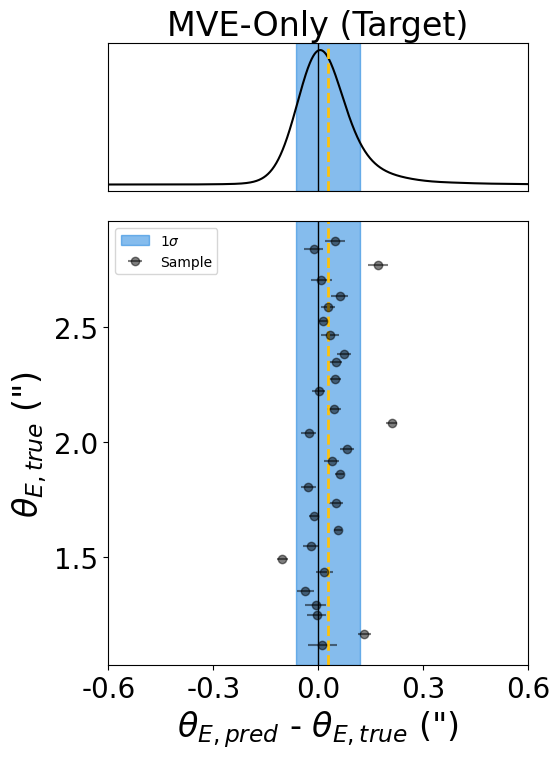

In [37]:
from scipy.stats import gaussian_kde
bins = np.linspace(1.1, 2.9, 60)
indices = np.digitize(true_target, bins) - 1 
ord_idx = np.array([np.random.choice(np.where((indices == k) & (var_preds_target > 0))[0], 1) for k in range(0, 60, 2)])
n_points = 30
rand_idx = ord_idx[:, 0]
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
lims = 0.6

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))

kde = gaussian_kde(resid_all, bw_method=0.5)
x_vals = np.linspace(-lims, lims, 1000)
kde_values = kde(x_vals)

# Plot the histogram
ax_hist.plot(x_vals, kde_values, color = 'k')
ax_hist.set_title('MVE-Only (Target)')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=true_target[rand_idx], xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k', label = "Sample")
ax_resid.set_xlabel(r'$\theta_{E, pred}$ - $\theta_{E, true}$ (")', fontsize = 24)
ax_resid.set_ylabel(r'$\theta_{E, true}$ (")', fontsize = 24)
ax_resid.axvline(0, color = 'k', ls = '-', lw = 1)
ax_hist.axvline(0, color = 'k', ls = '-', lw = 1)

#ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_hist.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_hist.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.legend(loc = 'upper left', fontsize = 10)
#ax_resid.sharex(ax_hist)
ax_hist.set_yticks([])

xt = np.linspace(-lims, lims, 5).round(2)
ax_resid.set_xticks(xt)
ax_resid.set_xticklabels(xt)

ax_hist.set_xticks([])
ax_hist.set_yticklabels([])
ax_hist.set_xlim(-lims, lims)
ax_resid.set_xlim(-lims, lims)
print(sv)

plt.tight_layout()
#plt.savefig("target_resid_noDA.png", bbox_inches = 'tight', dpi = 400)

### Calculating Coverage and Confidence Level

MVE-only is overconfident on target and well calibrated on source.

In [38]:
import scipy.stats as st
def calculate_coverage(preds, true, variance):
    """
    Calculates the fraction of images with correct prediction within each confidence level (0% - 100%).
    This assumes the variance is based on a gaussian distribution.
    
    E.g. In 100 lenses, if 30 lenses have predictions within a 50% confidence interval, the point
    (50, 30) will be present.

    At 0%, no lenses should be in the confidence interval. 
    At 100%, all lenses should be in the confidence interval.
    """

    # Convert variance to standard deviation
    sig = np.sqrt(variance)

    # Calculate zscore = (x - mu) / sig, and take absolute value, e.g. 1.96
    zscore = np.abs((preds - true) / sig)

    # Calculate the fraction of gaussian within zscore sigma for two-tailed gaussian
    one_tail_cl = st.norm.cdf(zscore) # e.g. cdf(1.96) = 0.975 = 97.5% of gaussian
    two_tail_cl = 1 - ((1 - one_tail_cl) * 2) # total gaussian - ((excluded 2.5% of gaussian) * 2)

    # Above (two_tail_cl)% confidence, image will be excluded from correct prediction
    # Equivalently, we can sort the array against the fraction of lenses
    confidence_level = np.sort(two_tail_cl)
    image_fraction = np.arange(len(two_tail_cl)) / len(two_tail_cl)

    return confidence_level, image_fraction

In [39]:
confidence_level_source, image_fraction_source = calculate_coverage(preds_source, true_source, var_preds_source)
confidence_level_target, image_fraction_target = calculate_coverage(preds_target, true_target, var_preds_target)

/tmp/ipykernel_1633/3207002130.py:18: RuntimeWarning: divide by zero encountered in divide
  zscore = np.abs((preds - true) / sig)


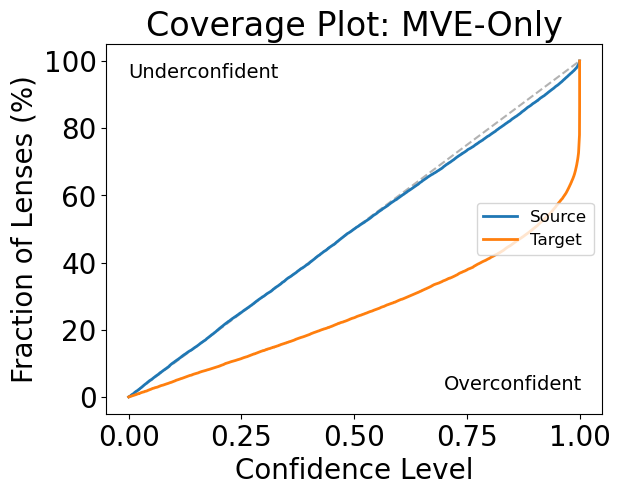

In [40]:
plt.title("Coverage Plot: MVE-Only")
plt.xlabel("Confidence Level")
plt.ylabel("Fraction of Lenses (%)")
plt.annotate("Underconfident", xy = (0, 95), fontsize = 14)
plt.annotate("Overconfident", xy = (0.7, 2), fontsize = 14)
plt.plot(confidence_level_source, confidence_level_source * 100, color = "k", ls = "--", alpha = 0.3)
plt.plot(confidence_level_source, image_fraction_source * 100, label = "Source", lw = 2)
plt.plot(confidence_level_target, image_fraction_target * 100, label = "Target", lw = 2)
plt.legend(fontsize = 12, loc = "center right")

### Looking at an Example Lensing System

2.55455704046247
tensor(2.1380)
tensor(0.0758)


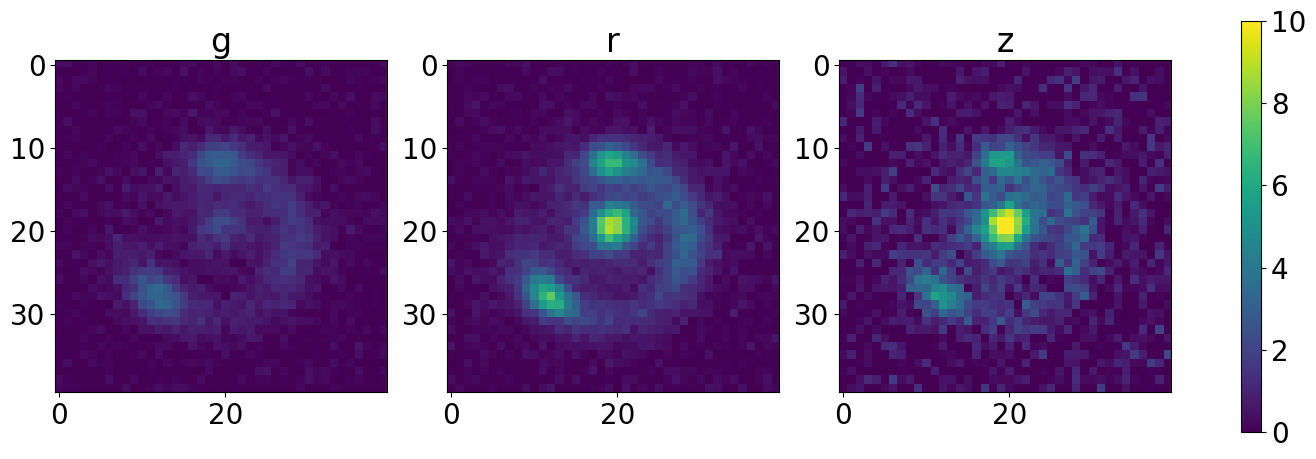

In [220]:
i = 16
img = targ_test[idx][i]

# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
im0 = axs[0].imshow(img[0, :, :])
axs[0].set_title('g')

# Second subplot
im1 = axs[1].imshow(img[1, :, :])
axs[1].set_title('r')

# Third subplot
im2 = s = axs[2].imshow(img[2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

vmin = 0
vmax = 10
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)
im0.set_clim(vmin, vmax)

print(np.array(label_target['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'])[idx][i])
print(preds_target_test[idx][i])
print(var_preds_target_test[idx][i])
# Show the plot
plt.colorbar(s, ax = axs)
plt.show()
